In [1]:
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap


## Part A: Preprocessing and Initial Setup

### 1. Data Loading

In [2]:
data, meta = arff.loadarff('yeast.arff')
df = pd.DataFrame(data)

In [3]:
df.head()

Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467  0.074686   
4  0.042037  0.007054 -0.069483  0.081015 -0.048207  0.089446 -0.004947   

       Att8      Att9     Att10  ...  Class5  Class6  Class7  Class8  Class9  \
0  0.041850  0.066938 -0.056617  ...    b'0'    b'0'    b'1'    b'1'    b'0'   
1 -0.077933 -0.080529 -0.016267  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
2  0.013646 -0.040666 -0.024447  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
3 -0.007670  0.079438  0.062184  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
4  0.064456 -0.133387  0.068878  ...    b'1'    b'1'    b'0'    b'0'    b'0'   

   Class10  Class11  Class12  Class13  Class14  
0     b'0'     b'0'     b'1'     b'1'     b'0'  
1     b'0'     b'0'     b'0'     b'0'     b'0'  
2     b'0'     b'0'     b'1'     b'1'     b'0'  
3     b'0'     b'0'     b'0'     b'0'     b'0'  
4     b'0'     b'0'     b'0'     b'0'     b'0'  

[5 rows x 117 columns]

In [4]:
m,n = df.shape
num_features = n - 14

In [5]:
X = df.iloc[:, :num_features]
y = df.iloc[:, num_features:]



### 2. Dimensionality Check

In [6]:

print(f"The initial shape of the dataset is ({m},{n})")
print(f"There are {num_features} features in the dataset")
print(f"The dataset consists of {m} datapoints")

The initial shape of the dataset is (2417,117)
There are 103 features in the dataset
The dataset consists of 2417 datapoints


### 2.1 Null Values Check

In [7]:
X.isna().sum()[X.isna().sum() > 0]

Series([], dtype: int64)

In [8]:
y.isna().sum()[y.isna().sum() > 0]

Series([], dtype: int64)

#### 2.2 Label Decoding

While loading **.arff** files using scipy.io.arff, it keeps binary labels as byte strings, like **b'0'** and **b'1'**. We need to convert them to integers so that we can perform arthimetic operations easily

In [11]:
y = y.apply(lambda col: col.str.decode('utf-8').astype(int))

### 3. Label Selection for Visualization

In [12]:
label_cnt_per_row = y.sum(axis=1)

single_label_vals = y[label_cnt_per_row == 1]
multi_label_vals = y[label_cnt_per_row > 1]

single_class_counts = single_label_vals.sum(axis=0)
multi_class_counts = multi_label_vals.apply(lambda x : tuple(x),axis=1).value_counts()


top2_sin_cls = single_class_counts.sort_values(ascending=False)[:2]
top_multi_cls = multi_class_counts.sort_values(ascending=False)[:1].index[0]





In [13]:
single_class_counts

Class1     32
Class2      0
Class3      0
Class4      0
Class5      0
Class6      0
Class7      0
Class8      0
Class9      0
Class10     0
Class11     0
Class12     0
Class13     0
Class14     0
dtype: int64

#### Considering Only one class ??

As we can form above data there is only one most common single class so considering that one only **Class1** as **frequent single-label classes**

In [14]:
top_sin_cls = top2_sin_cls.index[0]


In [15]:
def assgn_label(row):
    row_tuple = tuple(row)
    if row.sum() == 1 and row[top_sin_cls] == 1:
        return "Class1"
    elif row_tuple == top_multi_cls:
        return "MultiClass"
    else:
        return "Other"
    

In [16]:
df['data_vis'] = y.apply(lambda row: assgn_label(row), axis=1)

### 4 . Scaling

#### Why Scaling is crucial before applying distance-based dimensionality reduction ?

- Scaling is crucial in distance-based dimensionality reduction because the algorithms are highly sensitive to range of features.If features are on very different scales then the  features with larger scales will dominate the distance leading to distorted representation of the data.

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Part B: t-SNE and Veracity Inspection

### 1.​ t-SNE Implementation 

In [18]:
perplexity_list = [5, 30, 40, 50, 60, 70, 80, 90, 100,120,130,150,160,180,190,200]

tsne_results = {}

for per in perplexity_list:
    tsne = TSNE(n_components=2, perplexity=per, random_state=42)
    X_embedded = tsne.fit_transform(X_scaled)
    tsne_results[per] = X_embedded



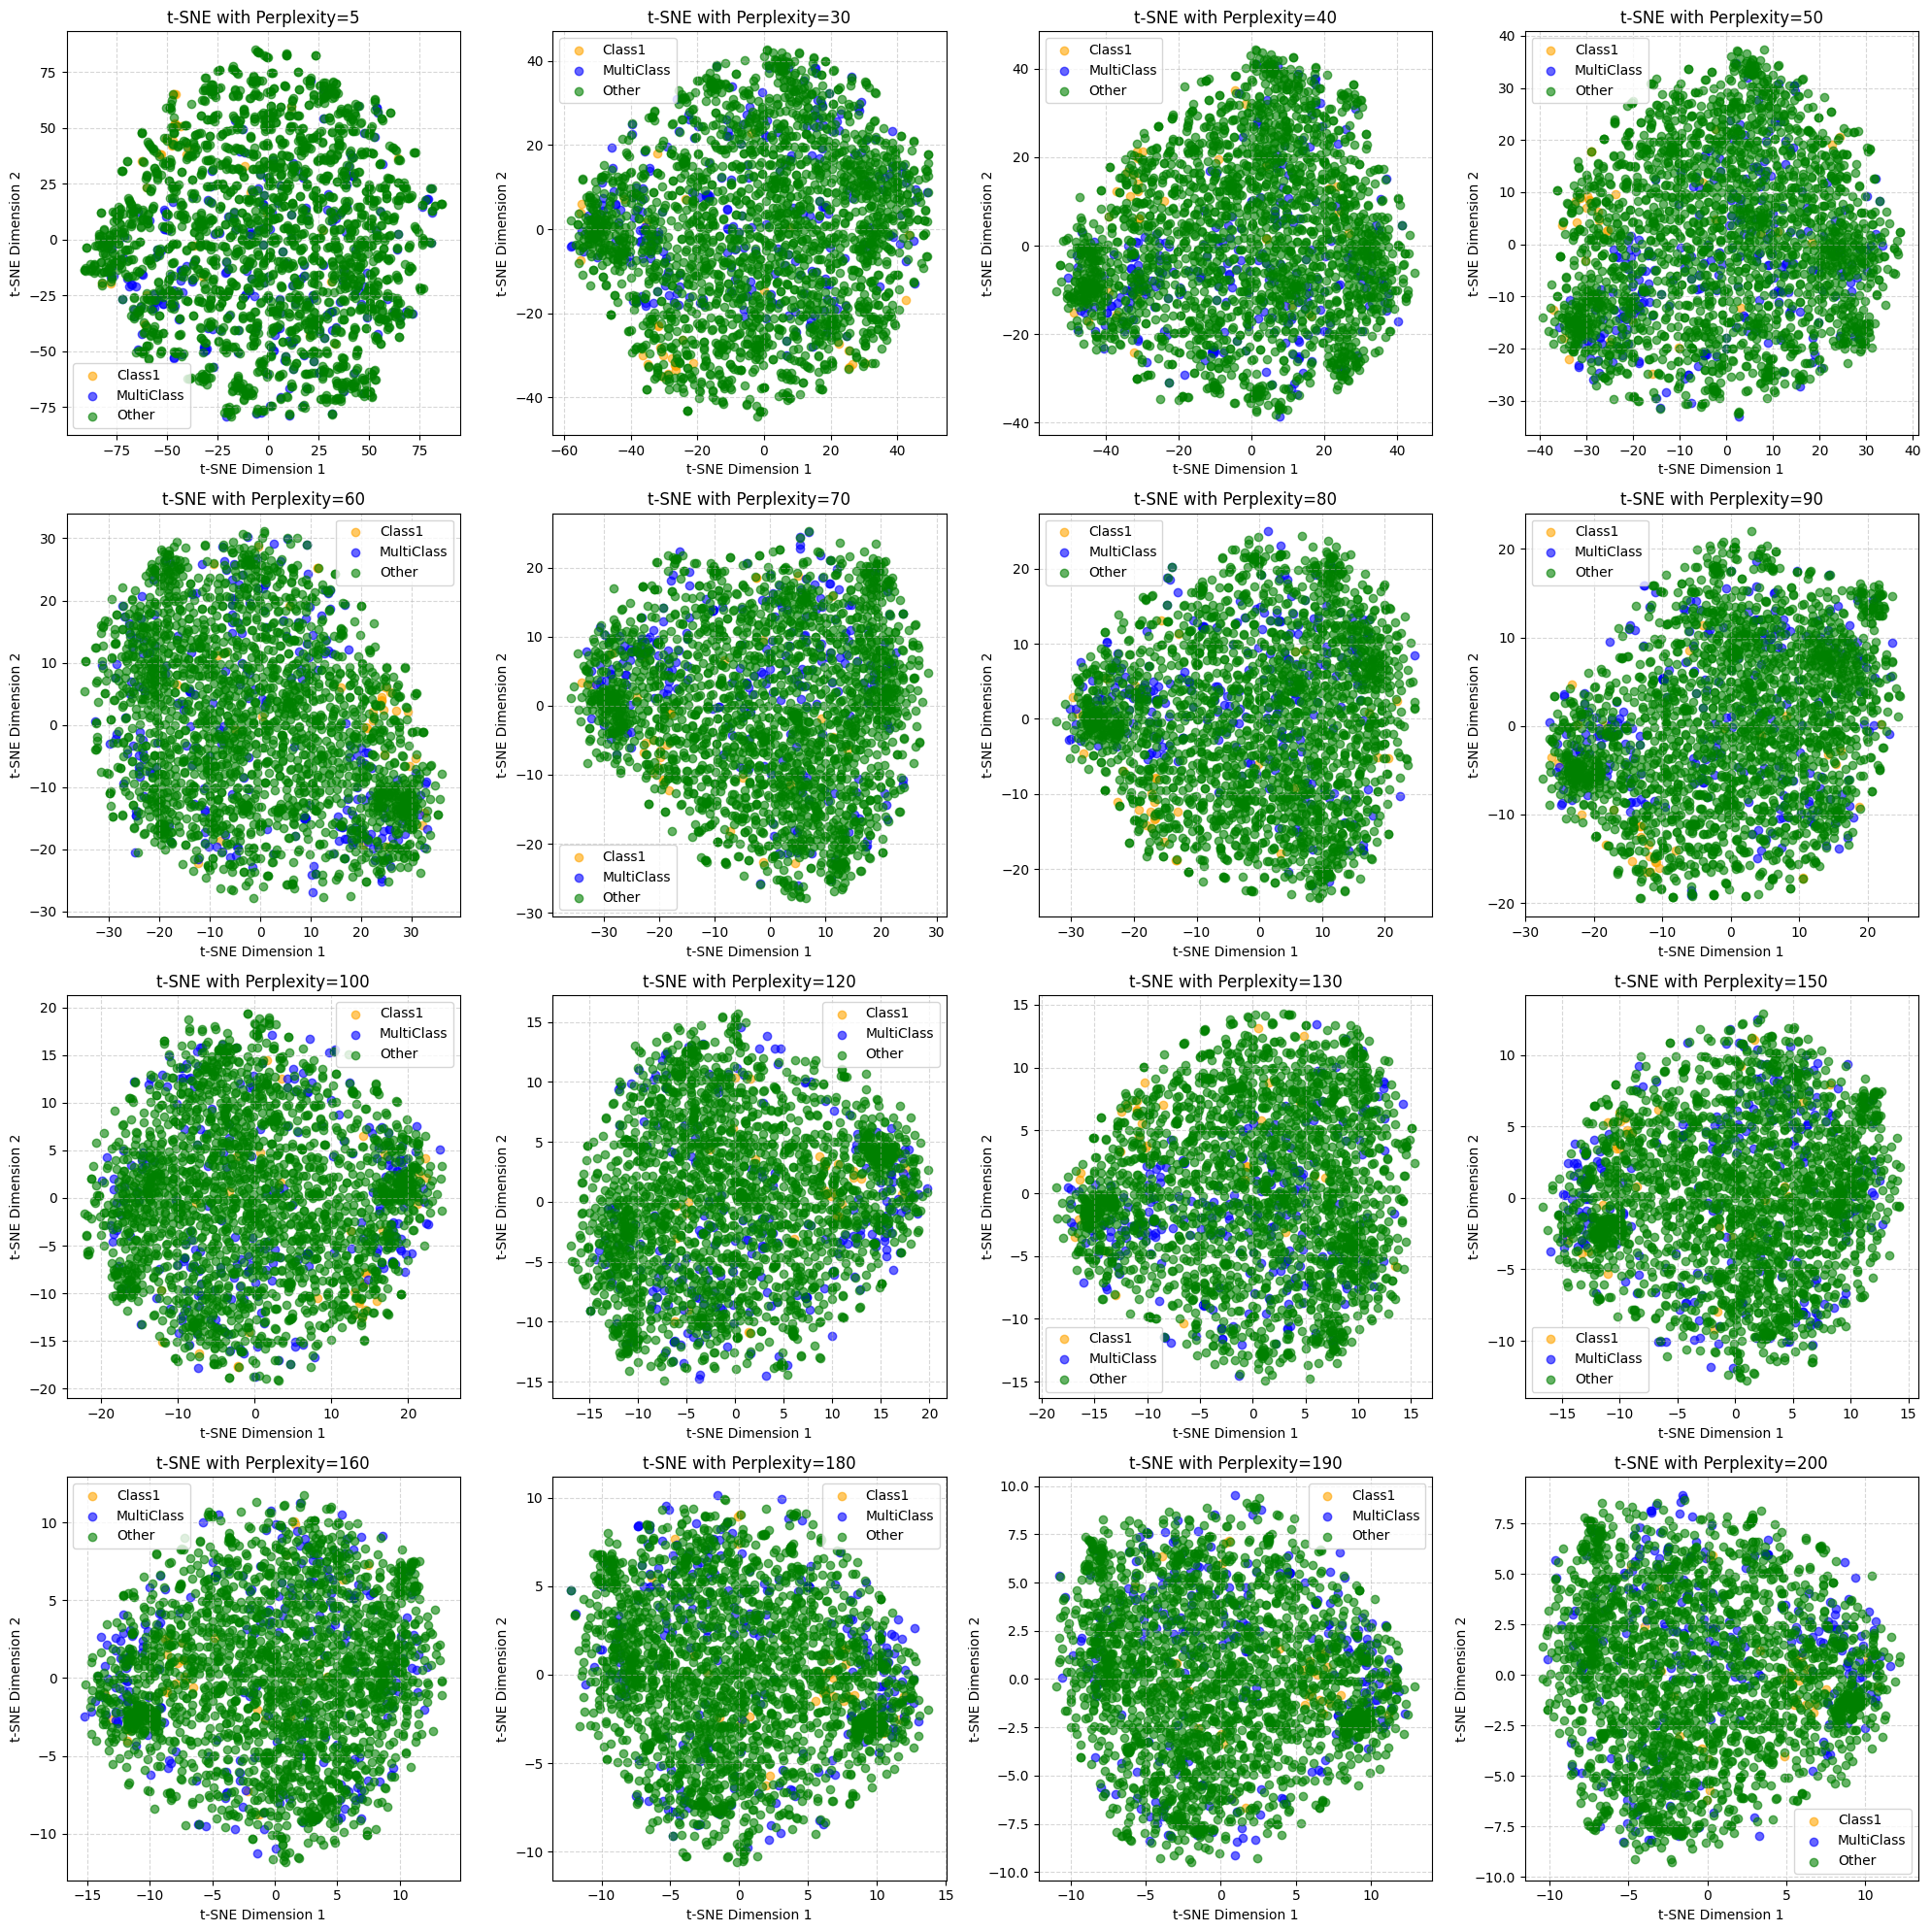

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()
labels = df['data_vis'].unique().tolist()


color_map = {
    "Class1": 'orange', 
    "MultiClass": 'blue', 
    "Other": 'green'
}

for i, per in enumerate(perplexity_list):
    ax = axes[i]
    X_embedded = tsne_results[per]
    
    for label, color in color_map.items():
        indices = df['data_vis'] == label        
        ax.scatter(X_embedded[indices, 0], X_embedded[indices, 1], c=color, label=label, alpha=0.6)

    ax.set_title(f't-SNE with Perplexity={per}')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.grid(True,linestyle='--',alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

#### What **perplexity** value to choose ?

I am thinking of taking **perplexity = 60** because:
- From 5 to 30 we can se e the plot are just revealing structure of the data no clustering happened
- From 30-60 clustering started we can see distinctive eclasses some what clearly although **Other** was pretty dominant value
- For higer values all values are clustering into single cluster which so we are not able see clearly the clusters as in 30-60 range

- For this reason I am choosing *perplexity = 60*

### 2. Visualization

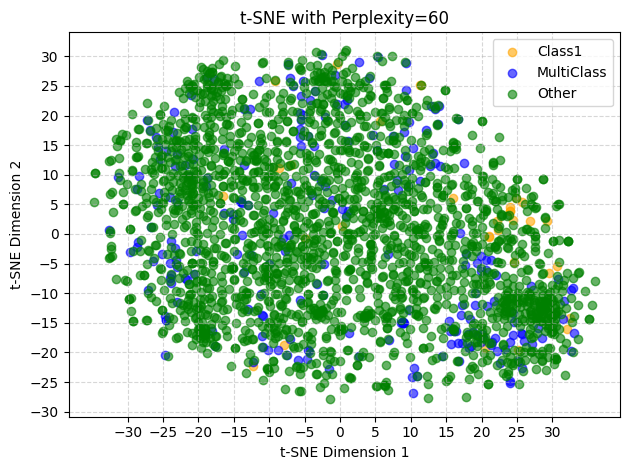

In [ ]:

X_embedded_60 = tsne_results[60]

for label, color in color_map.items():
    indices = df['data_vis'] == label        
    plt.scatter(X_embedded_60[indices, 0], X_embedded_60[indices, 1], c=color, label=label, alpha=0.6)

plt.title(f't-SNE with Perplexity={60}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.xticks(range(-30,31,5))
plt.yticks(range(-30,31,5))
plt.grid(True,linestyle='--',alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### 3. Veracity Inspection

#### 3.1 Noisy/Ambiguous Labels

- The points ts where one color is deeply embedded within a cluster of a different color.

- We can see in above plot **Class1** points are deeply embedded with in **Other** cluster points.

- This could be due to **high similarity** in expression patterns despite belonging to different categories, or due to **mislabeling** errors in the dataset.


#### 3.2 Outliers

- Outliers are Isolated points or tiny, distant clusters

- In the above diagram we can see a **dense cluster** at bottom right from **(20,10) to (30,10)** it is distanct from the data possibly representing a rare expression pattern.

- There are also few **single points** such as at top-left could be **outliers**

##### 3.2.1 Hypothesis 

- These unusual points may represent **rare or unique** patterns (e.g., rare yeast cell types) or could arise from **experimental errors / noise**.


#### 3.3 Hard-to-Learn Samples

- Areas where functional category colors are thoroughly mixed

- In the above we can see that **the central area** rougly from **x = -25 to x = 20** the points (*Class1,MultiClass,Other*) are thoroughly mixed without clear boundaries. This is hard to learn sample region

##### 3.3.1 Why a Simple classifier would likely struggle ??
- Here as mentioned above the points are mixed up without a clear linear or non linear boundary. And simple classifiers like **Logistic Regression** tries to find the boundary to classify the points which doesnt exist in the case.So it is difficult for a simple classifier to classify the points 

---
## Part C: Isomap and Manifold Learning

### 1. Isomap Implementation

#### 1.1 Difference between T-SNE  And Isomap

**Isomap : Preserve Global structure**
- Isomap tries to preserve the **overall shape** of the data .

- It calculates distance between *far-away  points* finds using **geodesic distance** which shortest path along the surface of the data manifold  instead of **Euclidean distance**.

- Then it applies Multidimensional Scaling on this geodesic distance matrix.

- As a result **relative positions** between far-apart points are maintained well.

- So it preserves the overall shape and layout of the entire dataset.It ensures that points that are far apart on the manifold remain far apart in the final visualization.


**t-SNE : Preserve Local structure**
- t-SNE focuses mainly on preserving **local neighborhood** of the data.

- It focuses on pairs of points that are close to each other in the high-dimensional space.
and tries to keep **nearby points close together** in the lower-dimensional map.

- It pays **less attention** to large distances, so far-away points can be placed arbitrarily as long as local neighborhoods are preserved.

- That makes t-SNE makes very good at preserving **local clusters**


In [21]:
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

### 2. Visualization

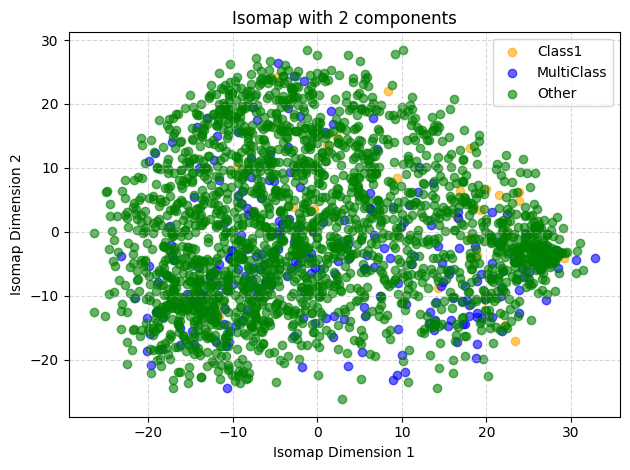

In [22]:

for label, color in color_map.items():
    indices = df['data_vis'] == label        
    plt.scatter(X_isomap[indices, 0], X_isomap[indices, 1], c=color, label=label, alpha=0.6)

plt.title(f'Isomap with 2 components')
plt.xlabel('Isomap Dimension 1')
plt.ylabel('Isomap Dimension 2')
plt.grid(True,linestyle='--',alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### 3. Comparison and Curvature

#### 3.1 Comparison of Isomap and t-SNE visualisation
- We can see both **t-SNE** and **Isomap** plots. In the t-SNE plots, we can observe that it forms distinct, dense clusters, but the overall shape is uneven, with small cluster regions.

- This is because t-SNE focuses on local neighbourhood preservation. So it tries to hold similar points tightly, that's the reason we observe small cluster regions in the plot, but the overall shape isn't preserved 

- But if we observe Isomap plots, the plots show more spread out and continuous points because its primary goal is to preserve geodesic distance  (the shortest distance between points along the underlying manifold of the data)

- By preserving this large-scale distance, Isomap effectively unfolds the data, providing a much clearer view of its global structure 

- Therefore, **Isomap** is better at revealing the global structure of the data.

#### 3.2 Data Manifold And its Curvature
- The data manifold concept assumes that high-dimensional data actually lie on a lower-dimensional manifold that is twisted and folded in the high-dimensional space.

- The points in Isomap are not showing linearly separable data.  Instead, the points are spread in a non-uniform way with no clear separation between the groups

- There isn't a simple straight line or a plane that would separate this data.

- This strongly suggests the underlying data manifold is complex, nonlinear, curved, and high-dimensional.

##### 3.2.1 Manifold complexity vs classification difficulty
- If the data lies on an imple manifold where classes occupy different regions. Then it's easy to classify them using just linear models

- But if the manifold is highly curved, then classes may overlap or their boundaries may be very nonlinear, making it harder for the classifiers to separate them.So we need more complex models to separate them.

- In summary, if the manifold is simple, linear classifiers are sufficient for the classification. If they are highly curved or complex, we need more advanced models for the classification



